ANCARANI ELISA - 0001026272

# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [41]:
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [43]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

(60000, 28, 28)
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [44]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

In [45]:
val_size = mnist_x_train.shape[0]//10 #validation set size 10% of the train set 
indices = np.arange(len(mnist_x_train))
np.random.shuffle(indices)
val_indices = indices[:val_size]
train_indices = indices[val_size:]

#validation set 
mnist_x_val = mnist_x_train[val_indices]
fashion_mnist_x_val = fashion_mnist_x_train[val_indices] 
print(f"mnist_x_val.shape={mnist_x_val.shape}")
#train set
fashion_mnist_x_train_new = fashion_mnist_x_train[train_indices]
mnist_x_train_new = mnist_x_train[train_indices]
print(f"mnist_x_train.shape={mnist_x_train.shape}")

mnist_x_val.shape=(6000, 32, 32)
mnist_x_train.shape=(60000, 32, 32)


## Before U-Net

First idea was to implement ResNetAE so an auto encoder architecture build with residual blocks.  I did not delve into this architecture because after several attempts I could not arrive at satisfactory results. I moved on to a more promising architecture for this task, the U-Net.


## U-NET

[U-Net](https://arxiv.org/abs/1505.04597) was fist introduced in 2015 for biomedical image segmentation tasks. The improvements it brought with respect to the previous state of the art model(ResNet) was to have an encoder-decoder architecture with skip connections between encoder and decoder layers. Skip connections prevents information loss and through residual connections U-Net allows to improve training and speed it up. Through skip connection we can face [Vanishing Gradient Problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) during training phase. The concept of U-net also works well in our case, i.e. in image separation. The data is encoded via an encoder, from the latent representation of the data two different decodings are performed, one per image. This is also called [Semi-Siamese Unet](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0246071) so the U-Net has been modified to make it a Semi-Siamese U-Net. Image below shows this architecture.

<div>
<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0246071.g001" width="600"/>
</div>

In addition, our architecture was modified by adding batch normalisation and dropout layers to each layer.  The batch normalisation layers were added to speed up and stabilise training, and also help with overfitting. These were also added after each convolutional layer. Dropout layers were added to avoid overfitting. 

### Some References
* https://github.com/zhixuhao/unet
* https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification
* https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
* https://arxiv.org/abs/1502.03167

In [46]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def decoder(*, drop5, drop4, conv3, conv2, conv1, dropout):
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Dropout(dropout)(conv6)
    conv6 = BatchNormalization()(conv6)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Dropout(dropout)(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Dropout(dropout)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Dropout(dropout)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    return conv10

def semi_siamese_unet(input_size = (256,256,1), dropout = 0.1): #dropout layer percentage
    inputs = Input(input_size)
    #inputs = BatchNormalization()(input)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2) 
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3) 
    pool3 = BatchNormalization()(pool3)
  
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    #DECODER OUTPUT
    out_decoder1 = decoder(drop5=drop5, drop4=drop4, conv3=conv3, conv2=conv2, conv1=conv1, dropout=dropout) 
    out_decoder2 = decoder(drop5=drop5, drop4=drop4, conv3=conv3, conv2=conv2, conv1=conv1, dropout=dropout) 

    model = Model(inputs, tf.concat((out_decoder1, out_decoder2), axis=2)) #concatenation of the decoders'output 

    return model

In [47]:
##### HYPERPARAMS #####
INPUT_SHAPE = (32, 32, 1)
BATCH_SIZE_UN = 128 
ABSOLUTE_STEPS = 1000 
STEPS_UN = int(500*ABSOLUTE_STEPS/BATCH_SIZE_UN) 
STEPS_VAL_UN = 100  
EPOCHS_UN= 45 
LEARNING_RATE_UN = 1e-2 
WEIGHT_DECAY_UN = 0

#### Metric Used

Metric used to measure the quality of the image separation process is mean squared error (MSE). 

While training the model, attempts were made with the optimisers [Adam](https://paperswithcode.com/method/adam) and [AdamW](https://paperswithcode.com/method/adamw). Weight decay however performed slightly worse, so in the end it was not used. 

The `model.compile` method connects the optimizer to the network parameters, so that they can be updated.


In [48]:
#DATA GENERATORS - VALIDATION - TRANING - TESTING
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, 1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, BATCH_SIZE_UN)
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, BATCH_SIZE_UN)

optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE_UN, weight_decay=WEIGHT_DECAY_UN) if WEIGHT_DECAY_UN > 0 else tf.optimizers.Adam(learning_rate=LEARNING_RATE_UN)

model_unet = semi_siamese_unet(INPUT_SHAPE) 

model_unet.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["mse"],
)

In [49]:
#Summary of the model, 43M params
model_unet.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_288 (Conv2D)            (None, 32, 32, 64)   640         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_204 (Batch  (None, 32, 32, 64)  256         ['conv2d_288[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_289 (Conv2D)            (None, 32, 32, 64)   36928       ['batch_normalization_204[

### Plot Model

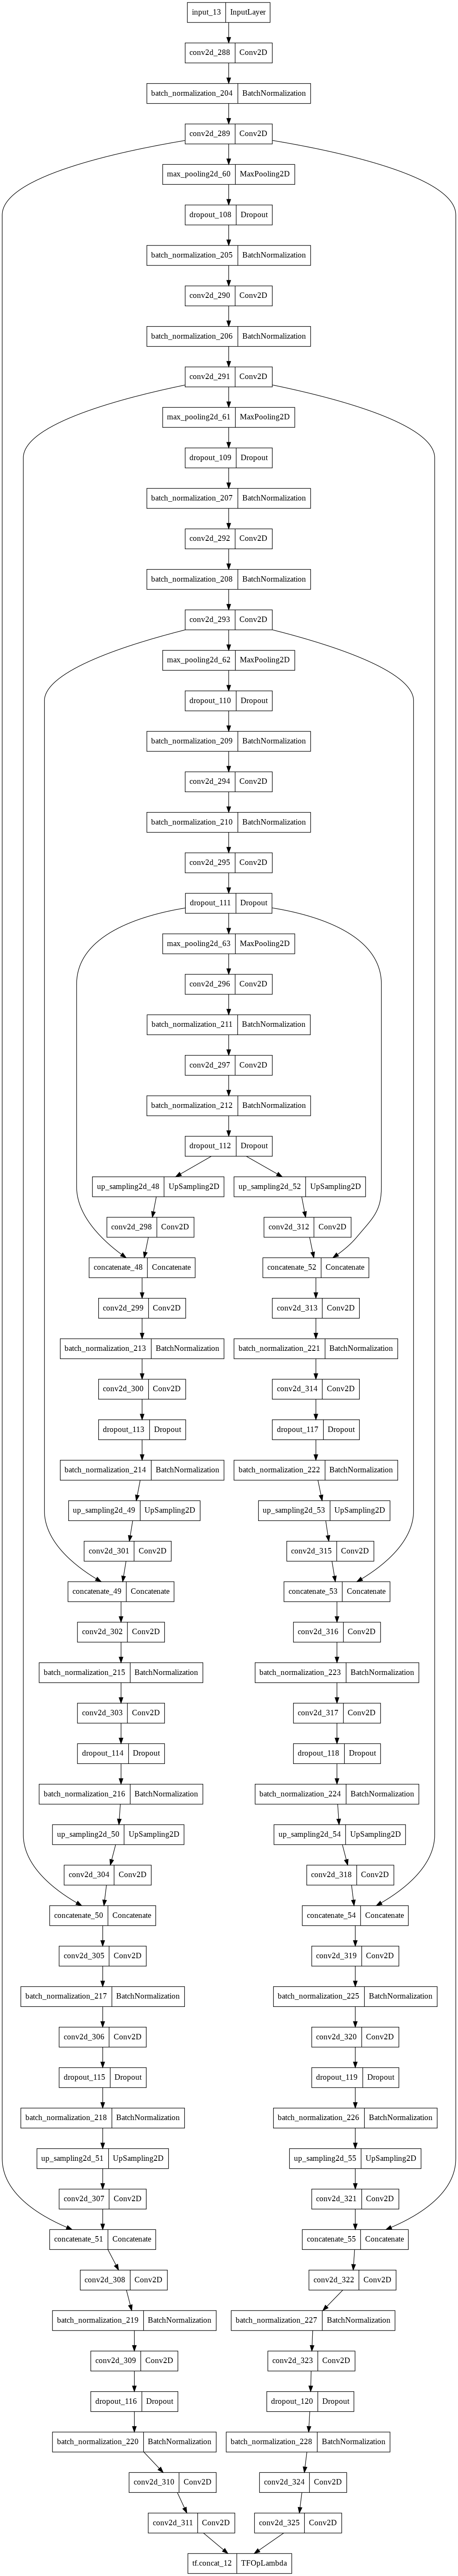

In [50]:
tf.keras.utils.plot_model(model_unet)

###  Training
Callbacks used: 
* EarlyStopping stops if no improvement is seen in `val_mse` for a  `patience` number of epochs
* ReduceLROnPlateau reduces the learning rate when the metric used doesn't improve anymore

Through `fit()` function it is possibile to form the model by cutting our data into batches of dimension `batch_size`, and iterate for a fixed number of complete passes through the training set, i.e `epochs`.

In [ ]:
reduce_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', min_lr=1e-8, factor=0.5, patience=2, verbose=1, mode='min') 
callback_early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=15, verbose=1, mode='min', restore_best_weights=True) 

callbacks_unet = [
                  callback_early_stopping,
                  reduce_on_plateau_callback
]

In [ ]:
train_history_s_unet = model_unet.fit(
    train_generator,
    validation_data =val_generator,
    epochs=EPOCHS_UN,
    verbose=1,
    steps_per_epoch= STEPS_UN,
    validation_steps = STEPS_VAL_UN, 
    callbacks = callbacks_unet
  ) 

Epoch 1/45
3906/3906 [==============================] - 662s 165ms/step - loss: 0.1263 - mse: 0.0036 - val_loss: 0.1183 - val_mse: 9.0733e-04 - lr: 0.0100
Epoch 2/45
3906/3906 [==============================] - 644s 165ms/step - loss: 0.1175 - mse: 8.5858e-04 - val_loss: 0.1191 - val_mse: 6.6151e-04 - lr: 0.0100
Epoch 3/45
3906/3906 [==============================] - 644s 165ms/step - loss: 0.1170 - mse: 7.1480e-04 - val_loss: 0.1219 - val_mse: 5.7195e-04 - lr: 0.0100
Epoch 4/45
3906/3906 [==============================] - 643s 165ms/step - loss: 0.1169 - mse: 6.3229e-04 - val_loss: 0.1108 - val_mse: 4.3786e-04 - lr: 0.0100
Epoch 5/45
3906/3906 [==============================] - 642s 164ms/step - loss: 0.1165 - mse: 5.7486e-04 - val_loss: 0.1239 - val_mse: 4.9141e-04 - lr: 0.0100
Epoch 6/45
3906/3906 [==============================] - ETA: 0s - loss: 0.1164 - mse: 5.4254e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3906/3906 [==========================

Minimum Achieved: 2.5737e-04

In [ ]:
import os
assert os.path.exists('/content/drive'), "You must mound drive first."
#model_unet.save_weights('/content/drive/MyDrive/a_exam_deep_learning/weights/UNet8Good.h5')

### Training Results

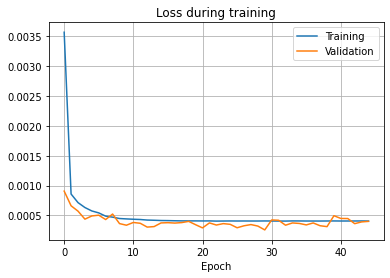

In [ ]:
def display_history(history):
    mse_training = history.history['mse']
    mse_val = history.history['val_mse']
    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

display_history(train_history_s_unet)

### Testing

Evaluation of the model on the test data through evaluate function. From the two test set are taken 20,000 randomly generated samples, and the computation is repeated 10 times. The generator producing `batch_size` samples at each call and for each step only one batch of data is evaluated.


In [ ]:
list_mse_unet = []
BATCH_SIZE_EVAL=256 #param to speed up evaluation
for elem in range(10):
  history=model_unet.evaluate(datagenerator(mnist_x_test,fashion_mnist_x_test, BATCH_SIZE_EVAL),steps=20000//BATCH_SIZE_EVAL, verbose=1)
  list_mse_unet.append(history[1]) #taking MSE

model_unet_mean = np.mean(list_mse_unet)
model_unet_std = np.std(list_mse_unet)

print("*"*32)
print("MEAN UNET", model_unet_mean)
print("STANDARD DEVIATION UNET", format(float(model_unet_std), '.10f'))
print("*"*32)

78/78 [==============================] - 7s 90ms/step - loss: 0.1161 - mse: 3.6712e-04
********************************
MEAN UNET 0.0003689008706714958
STANDARD DEVIATION UNET 0.0000023962
********************************


### Image Separation Result
Here's it is shown the image separation result, first image is the predicted image, second image is the true image.

(128, 32, 32)


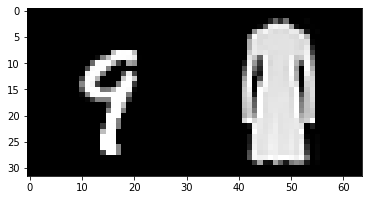

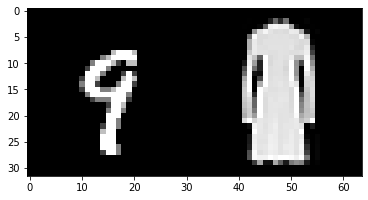

In [ ]:
x, y = next(test_generator)
print(x.shape)
y_pred = model_unet.predict(x)
plt.imshow(y_pred[0, :, :, 0], cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

### Train the model with weights

Open this cell for the weight-trained model. Now I try training the model with the weights saved from the previous training and a couple of epochs.

### **Result**: 
mean is a little bit lower 0.0003647!


In [ ]:
##### HYPERPARAMS #####
INPUT_SHAPE = (32, 32, 1)
BATCH_SIZE_UN = 128 
ABSOLUTE_STEPS = 1000 
STEPS_UN = int(500*ABSOLUTE_STEPS/BATCH_SIZE_UN) 
STEPS_VAL_UN = 100  
EPOCHS_UN= 10
LEARNING_RATE_UN = 1e-2
WEIGHT_DECAY_UN = 0 

reduce_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', min_lr=1e-8, factor=0.5, patience=2, verbose=1, mode='min') 
callback_early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, verbose=1, mode='min', restore_best_weights=True) 

callbacks_unet = [
    callback_early_stopping,
    reduce_on_plateau_callback
]

In [ ]:
import tensorflow_addons as tfa

#DATA GENERATORS - VALIDATION - TRANING - TESTING
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, 1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, BATCH_SIZE_UN)
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, BATCH_SIZE_UN)

optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE_UN, weight_decay=WEIGHT_DECAY_UN) if WEIGHT_DECAY_UN > 0 else tf.optimizers.Adam(learning_rate=LEARNING_RATE_UN)
#print(f"INPUT_SHAPE={INPUT_SHAPE}")
model_unet = semi_siamese_unet(INPUT_SHAPE) 

model_unet.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["mse"],
)

In [ ]:
model_unet.load_weights('/content/drive/MyDrive/a_exam_deep_learning/weights/UNet8Good.h5')

In [ ]:
train_history_s_unet_weights = model_unet.fit(
      train_generator,
      validation_data =val_generator,
      epochs=EPOCHS_UN,
      verbose=1,
      steps_per_epoch= STEPS_UN,
      validation_steps = STEPS_VAL_UN, 
      callbacks = callbacks_unet
  ) 

Epoch 1/10
3906/3906 [==============================] - 1232s 315ms/step - loss: 0.1161 - mse: 4.7807e-04 - val_loss: 0.1254 - val_mse: 4.6128e-04 - lr: 0.0100
Epoch 2/10
3906/3906 [==============================] - 1227s 314ms/step - loss: 0.1162 - mse: 4.6877e-04 - val_loss: 0.1112 - val_mse: 4.6056e-04 - lr: 0.0100
Epoch 3/10
3906/3906 [==============================] - ETA: 0s - loss: 0.1161 - mse: 4.6026e-04
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3906/3906 [==============================] - 1228s 314ms/step - loss: 0.1161 - mse: 4.6026e-04 - val_loss: 0.1170 - val_mse: 3.7390e-04 - lr: 0.0100
Epoch 4/10
3906/3906 [==============================] - 1228s 314ms/step - loss: 0.1160 - mse: 4.2844e-04 - val_loss: 0.1160 - val_mse: 3.7337e-04 - lr: 0.0050
Epoch 5/10
3906/3906 [==============================] - ETA: 0s - loss: 0.1160 - mse: 4.2012e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
3906/3906 [===============

In [ ]:
#model_unet.save_weights('/content/drive/MyDrive/a_exam_deep_learning/weights/UNet8GoodAfterWeightFit.h5')

In [ ]:
#TESTING
list_mse_unet_weights = []
BATCH_SIZE_EVAL=256 #hyperparam to speed up evaluation
for elem in range(10):
  history=model_unet.evaluate(datagenerator(mnist_x_test,fashion_mnist_x_test, BATCH_SIZE_EVAL),steps=20000//BATCH_SIZE_EVAL, verbose=1)
  list_mse_unet_weights.append(history[1]) #taking MSE

model_unet_w_mean = np.mean(list_mse_unet_weights)
model_unet_w_std = np.std(list_mse_unet_weights)

print("*"*32)
print("MEAN UNET", model_unet_w_mean)
print("STANDARD DEVIATION UNET", format(float(model_unet_w_std), '.10f'))
print("*"*32)


78/78 [==============================] - 11s 146ms/step - loss: 0.1164 - mse: 3.6554e-04
********************************
MEAN UNET 0.00036475079832598567
STANDARD DEVIATION UNET 0.0000029516
********************************


(128, 32, 32)


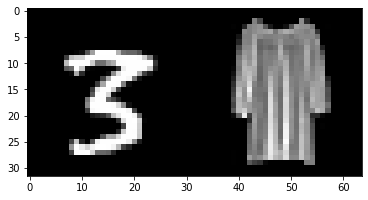

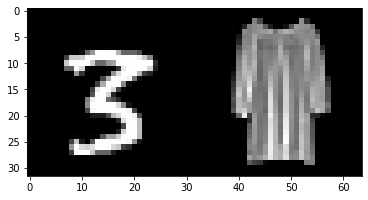

In [ ]:
### IMAGE RESULTS
x, y = next(test_generator)
print(x.shape)
y_pred = model_unet.predict(x)
plt.imshow(y_pred[0, :, :, 0], cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

## U-Net Second Version

I tried implementing another version of the unet, instead of having two decoders, trying to see this task as a two-labels image segmentation. Task for which the UNet is most well-suited. The resulting model will be much slimmer, as it has only one decoder instead of two. I also had to modify the last convolutional layer to output two channels (the two images). These will be then concatenated along the width to get an image of the desired shape (32, 64, 1).

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def decoder(*, drop5, drop4, conv3, conv2, conv1, dropout):
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Dropout(dropout)(conv6)
    conv6 = BatchNormalization()(conv6)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Dropout(dropout)(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Dropout(dropout)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Dropout(dropout)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    # print(conv9) 
    conv10 = Conv2D(2, 1, activation = 'sigmoid')(conv9) # two output channels instead of one.
    #print(conv10) 
    return conv10

def unet_one_decoder(input_size = (32,32,1), dropout = 0.1):
    inputs = Input(input_size)
    #inputs = BatchNormalization()(input)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    #one single decoder with the concatenation of the two output 
    out_decoder = decoder(drop5=drop5, drop4=drop4, conv3=conv3, conv2=conv2, conv1=conv1, dropout=dropout) 

    model = Model(inputs, tf.concat((out_decoder[:,:,:,0], out_decoder[:,:,:,1]), axis=2))

    return model

In [ ]:
##### HYPERPARAMS #####
INPUT_SHAPE = (32, 32, 1)
BATCH_SIZE_UN = 128 
ABSOLUTE_STEPS = 1000
STEPS_UN = int(500*ABSOLUTE_STEPS/BATCH_SIZE_UN) 
STEPS_VAL_UN = 100  
EPOCHS_UN= 45 
LEARNING_RATE_UN = 1e-2 
WEIGHT_DECAY_UN = 0 

### Metric Used

In [ ]:
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, 1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, BATCH_SIZE_UN)
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, BATCH_SIZE_UN)

optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE_UN, weight_decay=WEIGHT_DECAY_UN) if WEIGHT_DECAY_UN > 0 else tf.optimizers.Adam(learning_rate=LEARNING_RATE_UN)
print(f"INPUT_SHAPE={INPUT_SHAPE}")

model_unet_one_decoder = unet_one_decoder(INPUT_SHAPE) 

model_unet_one_decoder.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=["mse"],
)

INPUT_SHAPE=(32, 32, 1)


In [ ]:
model = unet_one_decoder((32, 32,1))
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_96 (Conv2D)             (None, 32, 32, 64)   640         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_68 (BatchN  (None, 32, 32, 64)  256         ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_97 (Conv2D)             (None, 32, 32, 64)   36928       ['batch_normalization_68[0]

### Plot Model

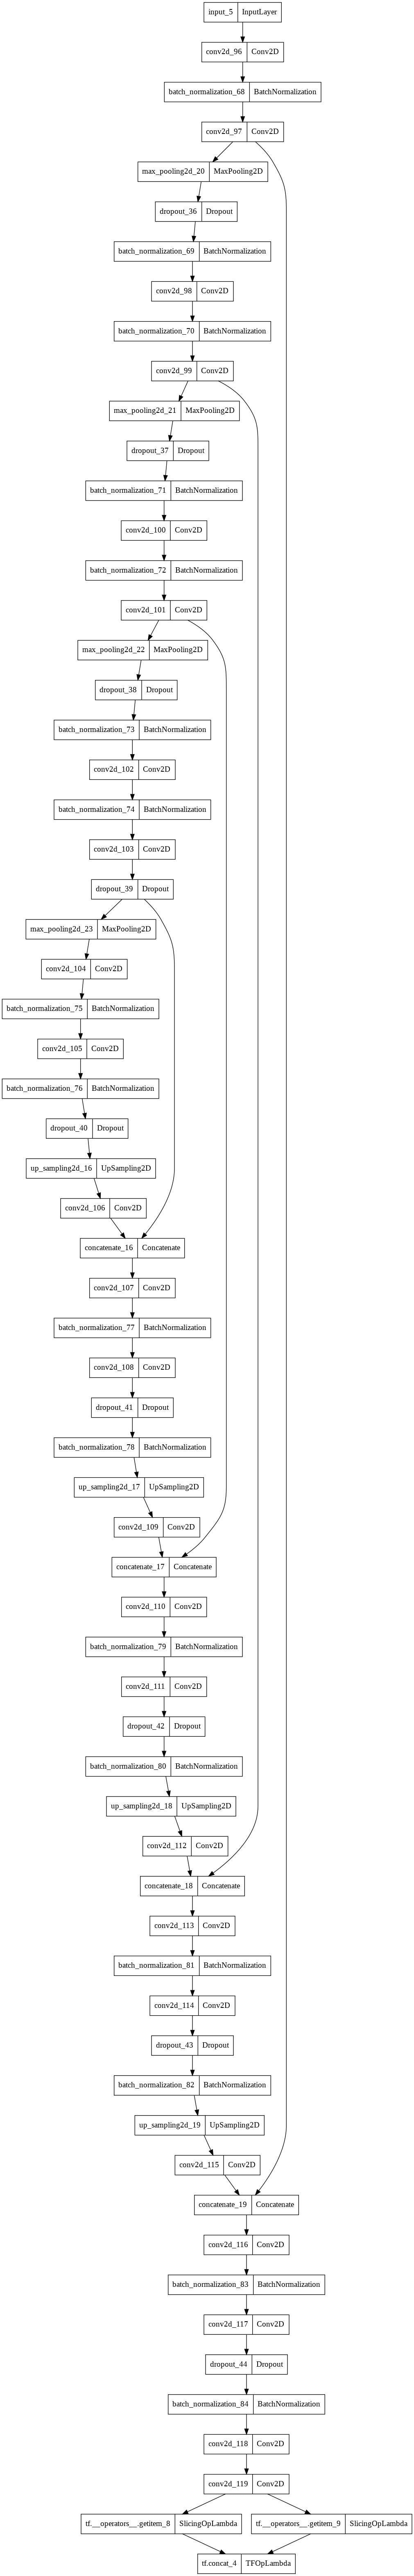

In [ ]:
tf.keras.utils.plot_model(model)

### Training

Training of the model is made using the same hyperparameters as Semi Siamese U-Net in order to make a comparison between the two model

In [ ]:
reduce_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', min_lr=1e-8, factor=0.5, patience=2, verbose=1, mode='min') 
callback_early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=15, verbose=1, mode='min', restore_best_weights=True) 

callbacks_unet = [
                 callback_early_stopping,
                 reduce_on_plateau_callback
]

In [ ]:
train_history_unet_one_decoder = model_unet_one_decoder.fit(
      train_generator,
      validation_data =val_generator,
      epochs=EPOCHS_UN,
      verbose=1,
      steps_per_epoch= STEPS_UN,
      validation_steps = STEPS_VAL_UN, 
      callbacks = callbacks_unet
  ) 

Epoch 1/45
3906/3906 [==============================] - 437s 102ms/step - loss: 0.1426 - mse: 0.0077 - val_loss: 0.1233 - val_mse: 0.0021 - lr: 0.0100
Epoch 2/45
3906/3906 [==============================] - 400s 102ms/step - loss: 0.1197 - mse: 0.0014 - val_loss: 0.1150 - val_mse: 8.0914e-04 - lr: 0.0100
Epoch 3/45
3906/3906 [==============================] - 400s 102ms/step - loss: 0.1183 - mse: 0.0011 - val_loss: 0.1177 - val_mse: 9.0166e-04 - lr: 0.0100
Epoch 4/45
3906/3906 [==============================] - ETA: 0s - loss: 0.1177 - mse: 8.7348e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3906/3906 [==============================] - 400s 102ms/step - loss: 0.1177 - mse: 8.7348e-04 - val_loss: 0.1163 - val_mse: 0.0010 - lr: 0.0100
Epoch 5/45
3906/3906 [==============================] - 400s 102ms/step - loss: 0.1170 - mse: 6.8066e-04 - val_loss: 0.1137 - val_mse: 4.5235e-04 - lr: 0.0050
Epoch 6/45
3906/3906 [==============================] - 400s 102

In [ ]:
model_unet_one_decoder.save_weights('/content/drive/MyDrive/a_exam_deep_learning/weights/UNet8-version2.h5')

### Training Results

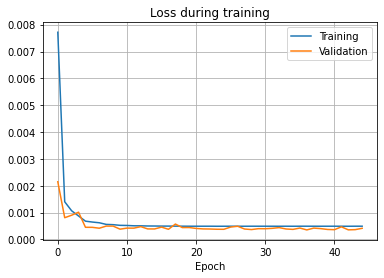

In [ ]:
def display_history(history):
    mse_training = history.history['mse']
    mse_val = history.history['val_mse']
    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

display_history(train_history_unet_one_decoder)

### Testing

In [ ]:
list_mse_unet_one_d_weights = []
BATCH_SIZE_EVAL=256 #hyperparam to speed up evaluation

for elem in range(10):
  history=model_unet_one_decoder.evaluate(datagenerator(mnist_x_test,fashion_mnist_x_test, BATCH_SIZE_EVAL),steps=20000//BATCH_SIZE_EVAL, verbose=1)
  list_mse_unet_one_d_weights.append(history[1]) #taking MSE

model_unet_w_one_d_mean = np.mean(list_mse_unet_one_d_weights)
model_unet_w_one_d_std = np.std(list_mse_unet_one_d_weights)

print("*"*32)
print("MEAN UNET", model_unet_w_one_d_mean)
print("STANDARD DEVIATION UNET", format(float(model_unet_w_one_d_std), '.10f'))
print("*"*32)

78/78 [==============================] - 4s 56ms/step - loss: 0.1167 - mse: 4.1860e-04
********************************
MEAN UNET 0.00041756833379622547
STANDARD DEVIATION UNET 0.0000034181
********************************


### Image Separation Result

(128, 32, 32)


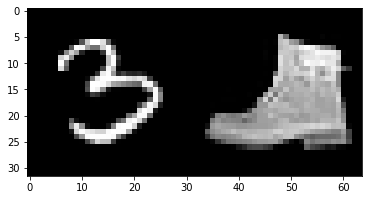

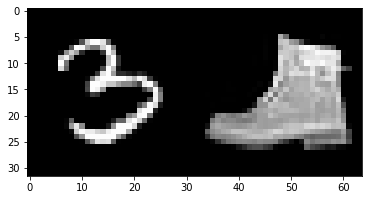

In [ ]:
### IMAGE RESULTS
x, y = next(test_generator)
print(x.shape)
y_pred = model_unet_one_decoder.predict(x)
plt.imshow(y_pred[0, :, :], cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

# Results and Conclusions

The two-classes UNet has performed worse than the Semi-Siamese one. Presumably, the reason is that this latter model has too few parameters to learn the task optimally. 


Model         | N° Params       | Epochs     | MSE            |   STD   |
--------------|-----------------|-----------|-----------------|----------
Semi-Siamese  |     43,2M         |    45     |  0.0003689      |    0.0000023962  |
U-Net         |     31M         |     45    | 0.0004175      |   0.0000034181    |

Semi Siamese U-Net trained with weights for 10 epochs achieved a result of: 0.0003647
### **BEST RESULT**: Semi Siamese U-Net with a MSE of: 0.0003689
With 43M parameters